# Fine Tuning BERT for Sentiment Analysis with PyTorch

References:
- [Fine Tuning BERT for Sentiment Analysis with PyTorch](https://wellsr.com/python/fine-tuning-bert-for-sentiment-analysis-with-pytorch/)
- [Twitter US Airline Sentiment](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?select=Tweets.csv)

- [RuntimeError: CUDA out of memory during loss.backward()](https://discuss.pytorch.org/t/runtimeerror-cuda-out-of-memory-during-loss-backward/53450/6)
- [Forms - Colaboratory](https://colab.research.google.com/notebooks/forms.ipynb)
- [Plotting loss curve](https://discuss.pytorch.org/t/plotting-loss-curve/42632/5)
- [Estratégias eficazes para lidar com conjuntos de dados desbalanceados](https://medium.com/@daniele.santiago/estrat%C3%A9gias-eficazes-para-lidar-com-conjuntos-de-dados-desbalanceados-5b873894483b)
- [Aprenda a balancear seus dados com Undersampling e Oversampling em Python](https://medium.com/@daniele.santiago/aprenda-a-balancear-seus-dados-com-undersampling-e-oversampling-em-python-6fd87095d717#:~:text=J%C3%A1%20o%20over%2Dsampling%2C%20por,t%C3%A9cnicas%20foi%20explicitada%20neste%20artigo.)
- [RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler.fit_resample)
- [REPRODUCIBILITY](https://pytorch.org/docs/stable/notes/randomness.html)

In [1]:
# @title Environment running
running_local = False
if running_local:
    running_colab = running_kaggle = False
else:
    running_colab = False  # @param {type:"boolean"}
    running_kaggle = not running_colab  # @param {type:"boolean"}

In [2]:
if running_colab:
    from google.colab import drive

    drive.mount("/content/drive")

## Installing and Importing Required Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import time
import torch
import torch.nn as nn

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

## Config

In [4]:
RANDOM_SEED = 103
TEST_SIZE = 0.2
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 5

TOKEN_MAX_LENGTH = 512
PRETRAINED_MODEL_PATH = "neuralmind/bert-base-portuguese-cased"
BERTIMBAU_HIDDEN_SIZE = 768

SAMPLE_REVIEWS = [
    "Empresa boa para trabalhar", # positive
    "Empresa ruim para trabalhar", # negative
    "Não tenho o que declarar", # neutral
]


if running_colab:
    GLASSDOOR_MODEL_PATH = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/bertimbau-glassdoor-reviews-epoch_5.bin"
    GLASSDOOR_FREEZING_MODEL_PATH = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/bertimbau-glassdoor-reviews-freezing-epoch_5.bin"
    PATH_TO_SAVE_MODEL = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/"
if running_kaggle:
    GLASSDOOR_MODEL_PATH = "/kaggle/working/bertimbau-glassdoor-reviews-epoch_5.bin"
    GLASSDOOR_FREEZING_MODEL_PATH = (
        "/kaggle/working/bertimbau-glassdoor-reviews-freezing-epoch_5.bin"
    )
    PATH_TO_SAVE_MODEL = "/kaggle/working/"
if running_local:
    GLASSDOOR_MODEL_PATH = "./bertimbau-glassdoor-reviews-epoch_5.bin"
    GLASSDOOR_FREEZING_MODEL_PATH = "./bertimbau-glassdoor-reviews-freezing-epoch_5.bin"
    PATH_TO_SAVE_MODEL = "./train_model/"

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: Tesla T4


In [6]:
torch.manual_seed(RANDOM_SEED)

In [7]:
random.seed(RANDOM_SEED)

In [8]:
np.random.seed(RANDOM_SEED)

## Importing and Preprocessing the Dataset

In [9]:
if running_colab:
    dataset = pd.read_csv(
        "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/data_preparation/glassdoor_reviews_annotated.csv"
    )
else:
    if running_kaggle:
        dataset = pd.read_csv(
            "/kaggle/input/glassdoor-reviews-annotated/glassdoor_reviews_annotated.csv"
        )
    else:
        dataset = pd.read_csv("../data_preparation/glassdoor_reviews_annotated.csv")

In [10]:
dataset.head(2)

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated
0,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano","Companheirismo entre os colegas, oportunidade ...",2023-12-15,5.0,1,0
1,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano",Não tive nenhum ponto negativo,2023-12-15,5.0,0,1


In [11]:
filtered_dataset = dataset.filter(["review_text", "sentiment"])

In [12]:
filtered_dataset.shape

(2532, 2)

In [13]:
filtered_dataset["sentiment"].value_counts()

sentiment
 1    1269
-1    1021
 0     242
Name: count, dtype: int64

In [14]:
num_labels = len(filtered_dataset["sentiment"].value_counts())

In [15]:
num_labels

3

In [16]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,-1
4,Única vantagem era o trabalho ser home office,0


Replace negative sentiment (-1) to 2, to avoid PyTorch errors.

In [17]:
filtered_dataset["sentiment"] = filtered_dataset["sentiment"].apply(
    lambda x: 2 if x == -1 else x
)

In [18]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,2
4,Única vantagem era o trabalho ser home office,0


Shuffle the data before splitting it into training and testing sets to remove any inherent ordering in the data that could bias the model's learning process.

In [19]:
filtered_dataset = filtered_dataset.sample(frac=1, random_state=RANDOM_SEED)

In [20]:
train_data, test_data = train_test_split(
    filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [21]:
train_data.shape

(2025, 2)

In [22]:
test_data.shape

(507, 2)

## Loading Bertimbau model

In [23]:
bertimbau = BertModel.from_pretrained(PRETRAINED_MODEL_PATH)

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [24]:
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Create a PyTorch Dataset

In [25]:
class GlassdoorReviewsDataset(Dataset):
    def __init__(self, data, tokenizer, token_max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = token_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]["review_text"]
        labels = self.data.iloc[index][["sentiment"]].values.astype(int)

        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=False,
            # max_length=self.max_length,
        )
        input_ids = encoding["input_ids"][0]
        attention_mask = encoding["attention_mask"][0]

        # resize the tensors to the same size
        input_ids = nn.functional.pad(
            input_ids, (0, self.max_length - input_ids.shape[0]), value=0
        )
        attention_mask = nn.functional.pad(
            attention_mask, (0, self.max_length - attention_mask.shape[0]), value=0
        )

        return input_ids, attention_mask, torch.tensor(labels)

In [26]:
train_dataset = GlassdoorReviewsDataset(train_data, tokenizer, TOKEN_MAX_LENGTH)
test_dataset = GlassdoorReviewsDataset(test_data, tokenizer, TOKEN_MAX_LENGTH)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Creating a PyTorch Model

In [28]:
classifier = nn.Sequential(
    nn.Linear(BERTIMBAU_HIDDEN_SIZE, 300),
    nn.ReLU(),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, num_labels),
)

In [29]:
class GlassdoorReviewsClassifier(nn.Module):
    def __init__(self, num_labels):
        super(GlassdoorReviewsClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(PRETRAINED_MODEL_PATH)
        self.classifier = classifier


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs["last_hidden_state"][:, 0, :]
        x = self.classifier(x)
        return x

In [30]:
class GlassdoorReviewsClassifierFreezing(nn.Module):
    def __init__(self, num_labels):
        super(GlassdoorReviewsClassifierFreezing, self).__init__()

        for param in bertimbau.parameters():
            param.requires_grad = False

        self.bert = BertModel.from_pretrained(PRETRAINED_MODEL_PATH)
        self.classifier = classifier

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs["last_hidden_state"][:, 0, :]
        x = self.classifier(x)
        return x

## Model training functions

In [31]:
def train(model, data_loader, loss_fun, optimizer, n_total_steps):
    model.train()

    running_loss = 0.0
    for i, batch in enumerate(data_loader):
        input_ids, attention_mask, labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        labels = labels.view(-1)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)

        loss = loss_fun(logits, labels)

        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        if (i + 1) % BATCH_SIZE == 0:
            print(
                f"Training Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
            )

    return running_loss / len(data_loader)

In [32]:
def test(model, data_loader, loss_fun, n_total_steps):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask)
            loss = loss_fun(logits, labels)

            loss_value = loss.item()
            running_loss += loss_value

            if (i + 1) % BATCH_SIZE == 0:
                print(
                    f"Evaluating Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
                )

    return running_loss / len(data_loader)

In [33]:
def show_loss(train_loss_per_epoch, test_loss_per_epoch, title):
    epochs = range(1, len(train_loss_per_epoch) + 1)

    train_data = {"epoch": epochs, "loss": train_loss_per_epoch, "type": "Train"}
    test_data = {"epoch": epochs, "loss": test_loss_per_epoch, "type": "Test"}
    df_loss = pd.concat([pd.DataFrame(train_data), pd.DataFrame(test_data)])

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df_loss, x="epoch", y="loss", hue="type", marker="o")

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # plt.grid(True)
    plt.legend(title="Loss Type")
    plt.show()

In [ ]:
def start_training(model, train_loader, loss_fun, optimizer, epochs, n_total_steps):
    train_losses = []
    test_losses = []
    start_time = time.time()

    for t in range(epochs):
        print(f"{'-'*20} Epoch: {t + 1}/{epochs} {'-'*20}")

        train_loss = train(model, train_loader, loss_fun, optimizer, n_total_steps)
        train_losses.append(train_loss)

        print("")

        test_loss = test(model, test_loader, loss_fun, n_total_steps)
        test_losses.append(test_loss)

        print(f"\nTrain Loss: {train_loss}, \t\t Test Loss: {test_loss}")
        print("\n\n")

    elapsed_time = time.time() - start_time
    print(f"Elapsed time: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")

    return train_losses, test_losses

## Model Evaluation functions

In [ ]:
def evaluate_model(model, test_loader, device):
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            _, predictions = torch.max(outputs, 1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(predictions.cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    return all_labels, all_preds

In [36]:
def show_confusion_matrix(all_labels, all_preds, normalize=None):
    cm = confusion_matrix(all_labels, all_preds, normalize=normalize)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [ ]:
def predict_reviews(model, reviews) -> None:
    class_names = ["neutral", "positive", "negative"]
    for review in reviews:
        encoded_review = tokenizer.encode_plus(
            review,
            max_length=TOKEN_MAX_LENGTH,
            add_special_tokens=True,
            return_token_type_ids=False,
            # pad_to_max_length=True, # deprecated
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        input_ids = encoded_review["input_ids"].to(device)
        attention_mask = encoded_review["attention_mask"].to(device)

        output = model(input_ids, attention_mask)
        _, prediction = torch.max(output, dim=1)
        probs = nn.functional.softmax(output, dim=1)

        print(f"Review text: {review}")
        # print(probs)
        print(pd.DataFrame(probs.tolist()[0], class_names)[0])
        print("\n")

    return None

## Training the Model (without oversampling)

In [38]:
model = GlassdoorReviewsClassifier(num_labels).to(device)
model_freezing = GlassdoorReviewsClassifierFreezing(num_labels).to(device)

In [39]:
loss_fun = nn.CrossEntropyLoss()

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer_freezing = torch.optim.Adam(model_freezing.parameters(), lr=LEARNING_RATE)

In [41]:
n_total_steps = len(train_loader)
n_total_steps

127

### Training Model without freezing BERT Layers

In [42]:
train_losses, test_losses = start_training(
    model, train_loader, loss_fun, optimizer, EPOCHS, n_total_steps
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/127, 		 loss = 1.0499
Training Batch 32/127, 		 loss = 0.9842
Training Batch 48/127, 		 loss = 0.8372
Training Batch 64/127, 		 loss = 0.6885
Training Batch 80/127, 		 loss = 0.7138
Training Batch 96/127, 		 loss = 0.5507
Training Batch 112/127, 		 loss = 0.8704

Evaluating Batch 16/127, 		 loss = 0.4548
Evaluating Batch 32/127, 		 loss = 0.5344

Train Loss: 0.7780915536279753, 		 Test Loss: 0.4972406132146716



-------------------- Epoch: 2/5 --------------------
Training Batch 16/127, 		 loss = 0.4066
Training Batch 32/127, 		 loss = 0.4747
Training Batch 48/127, 		 loss = 0.3283
Training Batch 64/127, 		 loss = 0.2822
Training Batch 80/127, 		 loss = 0.1937
Training Batch 96/127, 		 loss = 0.1689
Training Batch 112/127, 		 loss = 0.1154

Evaluating Batch 16/127, 		 loss = 0.5841
Evaluating Batch 32/127, 		 loss = 0.1196

Train Loss: 0.34459510580526564, 		 Test Loss: 0.2577943494543433



-------------------- Ep

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

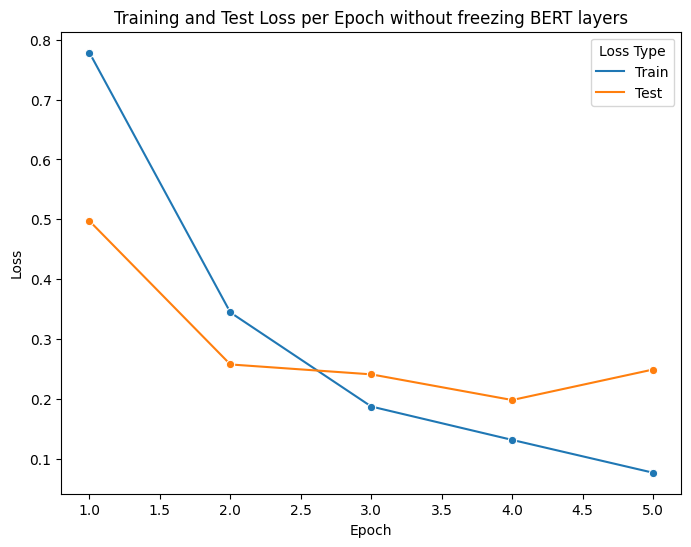

In [43]:
show_loss(train_losses, test_losses, title="Training and Test Loss per Epoch without freezing BERT layers")

#### Evaluating the Model

In [44]:
all_labels, all_preds = evaluate_model(model, test_loader, device)

In [45]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.75      0.76      0.76        51
           1       0.95      0.97      0.96       269
           2       0.96      0.91      0.94       187

    accuracy                           0.93       507
   macro avg       0.89      0.88      0.88       507
weighted avg       0.93      0.93      0.93       507



In [46]:
print(accuracy_score(all_labels, all_preds))

0.9309664694280079


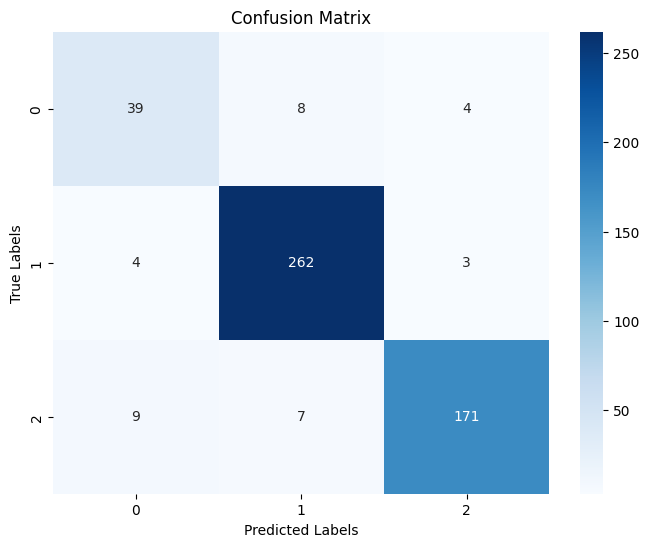

In [47]:
show_confusion_matrix(all_labels, all_preds)

In [48]:
# show_confusion_matrix(all_labels, all_preds, normalize="true")

#### Saving the model

In [49]:
torch.save(model.state_dict(), f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-epoch_{EPOCHS}.bin")

#### Loading the model

In [50]:
loaded_model = GlassdoorReviewsClassifier(num_labels).to(device)
loaded_model.load_state_dict(torch.load(GLASSDOOR_MODEL_PATH, map_location=device))
loaded_model.eval()

/tmp/ipykernel_30/2083525.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(GLASSDOOR_MODEL_PATH, map_location=device))


GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

#### Sample prediction

In [51]:
predict_reviews(model, SAMPLE_REVIEWS)

Review text: Empresa boa para trabalhar
neutral     0.006192
positive    0.990852
negative    0.002956
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.010504
positive    0.003919
negative    0.985577
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.934138
positive    0.037717
negative    0.028145
Name: 0, dtype: float64




### Training Model freezing BERT Layers

In [52]:
train_losses, test_losses = start_training(
    model_freezing, train_loader, loss_fun, optimizer_freezing, EPOCHS, n_total_steps
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/127, 		 loss = 0.6230
Training Batch 32/127, 		 loss = 0.5024
Training Batch 48/127, 		 loss = 0.7029
Training Batch 64/127, 		 loss = 0.2191
Training Batch 80/127, 		 loss = 0.1333
Training Batch 96/127, 		 loss = 0.3006
Training Batch 112/127, 		 loss = 0.0581

Evaluating Batch 16/127, 		 loss = 0.2553
Evaluating Batch 32/127, 		 loss = 0.0506

Train Loss: 0.3720335706951111, 		 Test Loss: 0.20823593472596258



-------------------- Epoch: 2/5 --------------------
Training Batch 16/127, 		 loss = 0.2092
Training Batch 32/127, 		 loss = 0.2484
Training Batch 48/127, 		 loss = 0.0968
Training Batch 64/127, 		 loss = 0.0257
Training Batch 80/127, 		 loss = 0.0429
Training Batch 96/127, 		 loss = 0.3029
Training Batch 112/127, 		 loss = 0.2328

Evaluating Batch 16/127, 		 loss = 0.2862
Evaluating Batch 32/127, 		 loss = 0.0214

Train Loss: 0.14813690777780034, 		 Test Loss: 0.19400340144056827



-------------------- 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

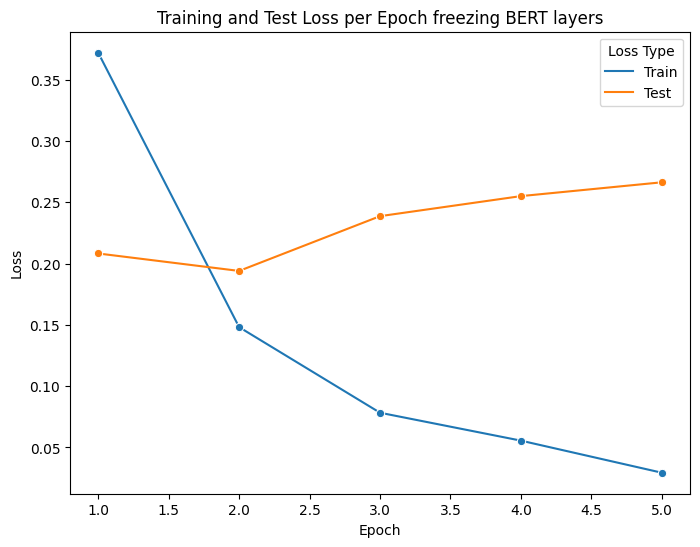

In [53]:
show_loss(train_losses, test_losses, title="Training and Test Loss per Epoch freezing BERT layers")

#### Evaluating the Model

In [54]:
all_labels, all_preds = evaluate_model(model_freezing, test_loader, device)

In [55]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84        51
           1       0.94      0.97      0.95       269
           2       0.94      0.95      0.94       187

    accuracy                           0.94       507
   macro avg       0.94      0.89      0.91       507
weighted avg       0.94      0.94      0.94       507



In [56]:
print(accuracy_score(all_labels, all_preds))

0.9388560157790927


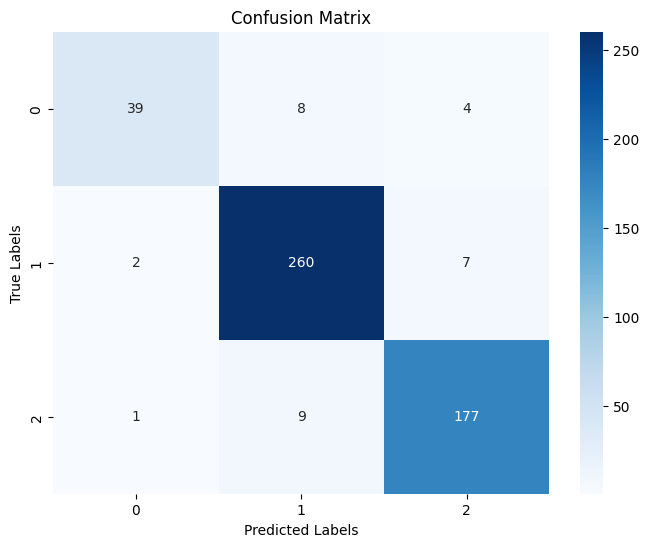

In [57]:
show_confusion_matrix(all_labels, all_preds)

In [58]:
# show_confusion_matrix(all_labels, all_preds, normalize="true")

#### Saving the model

In [59]:
torch.save(model.state_dict(), f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-freezing-epoch_{EPOCHS}.bin")

#### Loading the model

In [60]:
loaded_model = GlassdoorReviewsClassifier(num_labels).to(device)
loaded_model.load_state_dict(torch.load(GLASSDOOR_FREEZING_MODEL_PATH, map_location=device))
loaded_model.eval()

/tmp/ipykernel_30/1204538924.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(GLASSDOOR_FREEZING_MODEL_PATH, map_location=device))

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

##### Sample prediction

In [61]:
predict_reviews(loaded_model, SAMPLE_REVIEWS)

Review text: Empresa boa para trabalhar
neutral     0.000681
positive    0.999032
negative    0.000287
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.001302
positive    0.000296
negative    0.998402
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.991637
positive    0.004603
negative    0.003759
Name: 0, dtype: float64




## Training the model (with oversampling)

### Oversampling

In [62]:
def oversampling(train_df, minority_class=0, majority_classes=[1, 2]):
    # Desired number of samples for the minority class
    oversample_size = (
        train_df[train_df["sentiment"] == 0]["sentiment"].value_counts()[0] * 3
    )

    oversampler = RandomOverSampler(sampling_strategy={minority_class: oversample_size})
    X_res, y_res = oversampler.fit_resample(
        train_df[["review_text"]], train_df["sentiment"]
    )

    y_res_df = pd.DataFrame({"sentiment": y_res})
    resampled_df = pd.concat([X_res, y_res_df], axis=1)
    resampled_df.reset_index(drop=True, inplace=True)

    resampled_minority_df = resampled_df[resampled_df["sentiment"] == minority_class]

    # Concatenate the oversampled minority class with the majority class
    oversampled_df = pd.concat([train_df, resampled_minority_df])

    # Shuffle the DataFrame to randomize the order of samples
    oversampled_df = oversampled_df.sample(
        frac=1, random_state=RANDOM_SEED
    ).reset_index(drop=True)
    return oversampled_df

In [63]:
filtered_dataset.shape

(2532, 2)

In [64]:
filtered_dataset["sentiment"].value_counts()

sentiment
1    1269
2    1021
0     242
Name: count, dtype: int64

In [65]:
oversampled_filtered_dataset = oversampling(filtered_dataset)

In [66]:
oversampled_filtered_dataset.shape

(3258, 2)

In [67]:
oversampled_filtered_dataset["sentiment"].value_counts()

sentiment
1    1269
2    1021
0     968
Name: count, dtype: int64

### Training the Model

In [68]:
oversampled_train_data, oversampled_test_data = train_test_split(
    oversampled_filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [69]:
oversampled_train_dataset = GlassdoorReviewsDataset(
    oversampled_train_data, tokenizer, TOKEN_MAX_LENGTH
)

oversampled_test_dataset = GlassdoorReviewsDataset(
    oversampled_test_data, tokenizer, TOKEN_MAX_LENGTH
)

In [70]:
oversampled_train_loader = DataLoader(
    oversampled_train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
oversampled_test_loader = DataLoader(
    oversampled_test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [71]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model_freezing = GlassdoorReviewsClassifierFreezing(num_labels).to(device)

In [72]:
loss_fun = nn.CrossEntropyLoss()

In [73]:
oversampled_optimizer = torch.optim.Adam(
    oversampled_model.parameters(), lr=LEARNING_RATE
)
oversampled_optimizer_freezing = torch.optim.Adam(
    oversampled_model_freezing.parameters(), lr=LEARNING_RATE
)

In [74]:
n_total_steps = len(oversampled_train_loader)
n_total_steps

163

#### Train without freezing

In [75]:
oversampled_train_losses, oversampled_test_losses = start_training(
    oversampled_model,
    oversampled_train_loader,
    loss_fun,
    oversampled_optimizer,
    EPOCHS,
    n_total_steps,
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/163, 		 loss = 0.4817
Training Batch 32/163, 		 loss = 0.2817
Training Batch 48/163, 		 loss = 0.5797
Training Batch 64/163, 		 loss = 0.2278
Training Batch 80/163, 		 loss = 0.1321
Training Batch 96/163, 		 loss = 0.1118
Training Batch 112/163, 		 loss = 0.0728
Training Batch 128/163, 		 loss = 0.3568
Training Batch 144/163, 		 loss = 0.2416
Training Batch 160/163, 		 loss = 0.3917

Evaluating Batch 16/163, 		 loss = 0.0408
Evaluating Batch 32/163, 		 loss = 0.0208

Train Loss: 0.3118100127239534, 		 Test Loss: 0.10036603716434911



-------------------- Epoch: 2/5 --------------------
Training Batch 16/163, 		 loss = 0.0793
Training Batch 32/163, 		 loss = 0.0608
Training Batch 48/163, 		 loss = 0.0234
Training Batch 64/163, 		 loss = 0.0139
Training Batch 80/163, 		 loss = 0.0255
Training Batch 96/163, 		 loss = 0.0372
Training Batch 112/163, 		 loss = 0.0169
Training Batch 128/163, 		 loss = 0.2989
Training Batc

##### Evaluating the Model

In [76]:
len(oversampled_train_losses)

5

In [77]:
len(oversampled_test_losses)

5

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

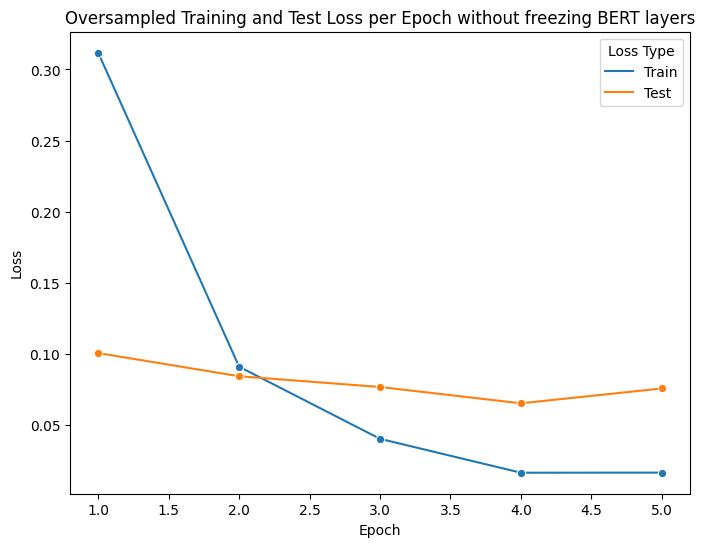

In [78]:
show_loss(oversampled_train_losses, oversampled_test_losses, title="Oversampled Training and Test Loss per Epoch without freezing BERT layers")

In [79]:
oversampled_all_labels, oversampled_all_preds = evaluate_model(
    oversampled_model, oversampled_test_loader, device
)

In [80]:
print(classification_report(oversampled_all_labels, oversampled_all_preds))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       197
           1       0.93      0.96      0.95       256
           2       0.98      0.89      0.93       199

    accuracy                           0.95       652
   macro avg       0.95      0.95      0.95       652
weighted avg       0.95      0.95      0.95       652



In [81]:
print(accuracy_score(oversampled_all_labels, oversampled_all_preds))

0.946319018404908


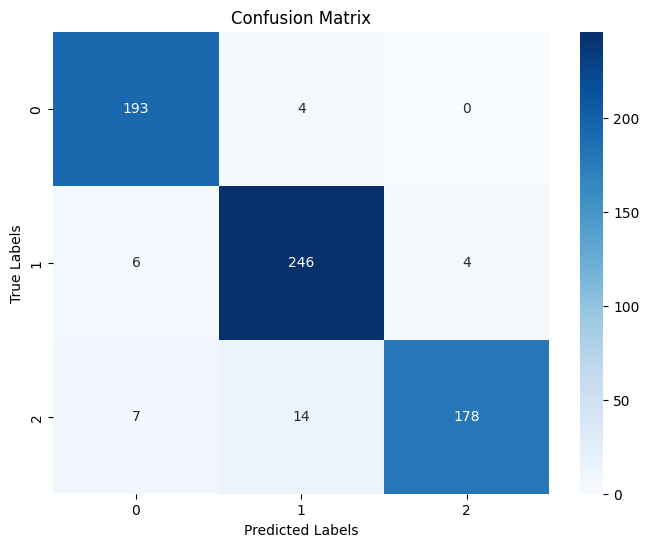

In [82]:
show_confusion_matrix(oversampled_all_labels, oversampled_all_preds)

##### Saving the model

In [83]:
torch.save(
    oversampled_model.state_dict(),
    f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-oversampled-epoch_{EPOCHS}.bin",
)

##### Loading the model

In [84]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model.load_state_dict(
    torch.load(
        GLASSDOOR_MODEL_PATH.replace(
            f"bertimbau-glassdoor-reviews-epoch_5.bin",
            f"bertimbau-glassdoor-reviews-oversampled-epoch_{EPOCHS}.bin",
        ),
        map_location=device,
    )
)
oversampled_model.eval()

/tmp/ipykernel_30/2244661212.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

##### Sample prediction

In [85]:
predict_reviews(oversampled_model, SAMPLE_REVIEWS)

Review text: Empresa boa para trabalhar
neutral     0.000504
positive    0.999092
negative    0.000404
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.001586
positive    0.005797
negative    0.992618
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.998764
positive    0.000732
negative    0.000505
Name: 0, dtype: float64




#### Train freezing

In [86]:
oversampled_train_losses, oversampled_test_losses = start_training(
    oversampled_model_freezing,
    oversampled_train_loader,
    loss_fun,
    oversampled_optimizer_freezing,
    EPOCHS,
    n_total_steps,
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/163, 		 loss = 0.4764
Training Batch 32/163, 		 loss = 0.1694
Training Batch 48/163, 		 loss = 0.0943
Training Batch 64/163, 		 loss = 0.3645
Training Batch 80/163, 		 loss = 0.1174
Training Batch 96/163, 		 loss = 0.3783
Training Batch 112/163, 		 loss = 0.3781
Training Batch 128/163, 		 loss = 0.2588
Training Batch 144/163, 		 loss = 0.0599
Training Batch 160/163, 		 loss = 0.0490

Evaluating Batch 16/163, 		 loss = 0.0432
Evaluating Batch 32/163, 		 loss = 0.0503

Train Loss: 0.29091294572625787, 		 Test Loss: 0.08791896360344253



-------------------- Epoch: 2/5 --------------------
Training Batch 16/163, 		 loss = 0.0667
Training Batch 32/163, 		 loss = 0.0199
Training Batch 48/163, 		 loss = 0.1925
Training Batch 64/163, 		 loss = 0.0385
Training Batch 80/163, 		 loss = 0.0124
Training Batch 96/163, 		 loss = 0.0231
Training Batch 112/163, 		 loss = 0.0377
Training Batch 128/163, 		 loss = 0.0175
Training Bat

##### Evaluating the Model

In [87]:
len(oversampled_train_losses)

5

In [88]:
len(oversampled_test_losses)

5

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

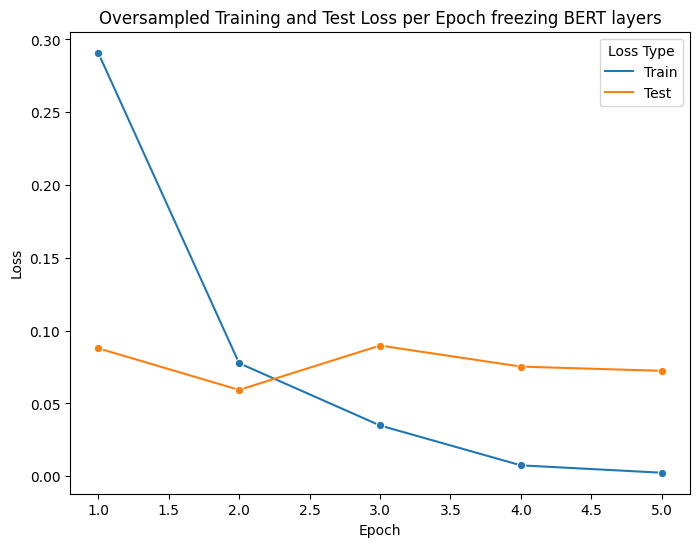

In [89]:
show_loss(
    oversampled_train_losses,
    oversampled_test_losses,
    title="Oversampled Training and Test Loss per Epoch freezing BERT layers",
)

In [90]:
oversampled_all_labels, oversampled_all_preds = evaluate_model(
    oversampled_model_freezing, oversampled_test_loader, device
)

In [91]:
print(classification_report(oversampled_all_labels, oversampled_all_preds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       197
           1       0.95      0.98      0.96       256
           2       0.98      0.93      0.96       199

    accuracy                           0.97       652
   macro avg       0.97      0.96      0.97       652
weighted avg       0.97      0.97      0.97       652



In [92]:
print(accuracy_score(oversampled_all_labels, oversampled_all_preds))

0.9662576687116564


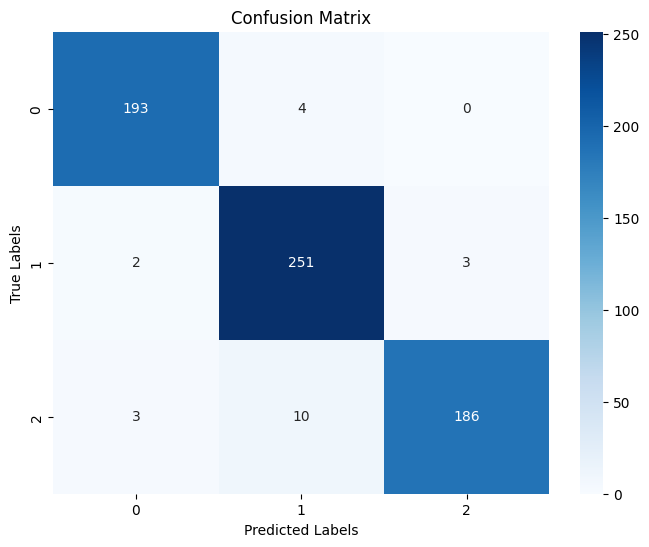

In [93]:
show_confusion_matrix(oversampled_all_labels, oversampled_all_preds)

##### Saving the model

In [94]:
torch.save(
    oversampled_model.state_dict(),
    f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-oversampled-freezing-epoch_{EPOCHS}.bin",
)

##### Loading the model

In [95]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model.load_state_dict(
    torch.load(
        GLASSDOOR_MODEL_PATH.replace(
            f"bertimbau-glassdoor-reviews-epoch_5.bin",
            f"bertimbau-glassdoor-reviews-oversampled-freezing-epoch_{EPOCHS}.bin",
        ),
        map_location=device,
    )
)
oversampled_model.eval()

/tmp/ipykernel_30/1612729092.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

##### Sample prediction

In [96]:
predict_reviews(oversampled_model, SAMPLE_REVIEWS)

Review text: Empresa boa para trabalhar
neutral     0.000094
positive    0.999820
negative    0.000086
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.000337
positive    0.002157
negative    0.997506
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.999794
positive    0.000136
negative    0.000070
Name: 0, dtype: float64


